# RETAIL CUSTOMER CLASSIFICATION ANALYSIS

In [ ]:
# Core data manipulation libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Date/time operations
from datetime import datetime, timedelta
import calendar

# Statistical analyses
from scipy import stats
from scipy.stats import chi2_contingency

# Scikit-learn libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans

# Classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# DATA LOADING AND INITIAL OVERVIEW

In [31]:
# Load Excel file (not CSV since file is .xlsx)
try:
    df = pd.read_excel('Online Retail.xlsx')
    print("Excel file successfully loaded!")
    print(f"Dataset shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
    
    # Display basic information about the dataset
    print(f"\nDATASET OVERVIEW:")
    print("="*50)
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("Online Retail.xlsx' file not found. Please check the file path.")
except ImportError:
    print("'openpyxl' library required for Excel files.")
    print("Run in terminal: pip install openpyxl")

# Display first 5 rows to understand data structure
print(f"\nFIRST 5 ROWS:")
print("="*80)
display(df.head())

# Show column names and data types
print(f"\nCOLUMN INFORMATION:")
print("="*40)
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col:<15} - {df[col].dtype}")

Excel file successfully loaded!
Dataset shape: 541,909 rows, 8 columns

DATASET OVERVIEW:
Memory usage: 33.08 MB

FIRST 5 ROWS:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



COLUMN INFORMATION:
1. InvoiceNo       - object
2. StockCode       - object
3. Description     - object
4. Quantity        - int64
5. InvoiceDate     - datetime64[ns]
6. UnitPrice       - float64
7. CustomerID      - float64
8. Country         - object


# MISSING DATA ANALYSIS AND DATA QUALITY CHECK

In [32]:
# Check for missing values in each column
print("MISSING DATA ANALYSIS:")
print("="*50)
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

missing_summary = pd.DataFrame({
    'Column': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percentage (%)': missing_percentage.values
}).sort_values('Missing Count', ascending=False)

display(missing_summary)

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\nDUPLICATE ANALYSIS:")
print("="*30)
print(f"Total duplicate rows: {duplicate_count:,}")
print(f"Duplicate percentage: {(duplicate_count/len(df)*100):.2f}%")

# Check data quality issues
print(f"\nDATA QUALITY CHECKS:")
print("="*40)

# Negative quantities (returns/cancellations)
negative_qty = (df['Quantity'] < 0).sum()
print(f"Negative quantities: {negative_qty:,} ({negative_qty/len(df)*100:.2f}%)")

# Zero or negative unit prices
zero_price = (df['UnitPrice'] <= 0).sum()
print(f"Zero/negative unit prices: {zero_price:,} ({zero_price/len(df)*100:.2f}%)")

# Missing customer IDs
missing_customers = df['CustomerID'].isnull().sum()
print(f"Missing customer IDs: {missing_customers:,} ({missing_customers/len(df)*100:.2f}%)")

# Check unique values count
print(f"\nUNIQUE VALUES COUNT:")
print("="*35)
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col:<15}: {unique_count:>8,} unique values")

MISSING DATA ANALYSIS:


,Column,Missing Count,Missing Percentage (%)
6,CustomerID,135080,24.926694
2,Description,1454,0.268311
1,StockCode,0,0.000000
0,InvoiceNo,0,0.000000
3,Quantity,0,0.000000
4,InvoiceDate,0,0.000000
5,UnitPrice,0,0.000000
7,Country,0,0.000000



DUPLICATE ANALYSIS:
Total duplicate rows: 5,268
Duplicate percentage: 0.97%

DATA QUALITY CHECKS:
Negative quantities: 10,624 (1.96%)
Zero/negative unit prices: 2,517 (0.46%)
Missing customer IDs: 135,080 (24.93%)

UNIQUE VALUES COUNT:
InvoiceNo      :   25,900 unique values
StockCode      :    4,070 unique values
Description    :    4,223 unique values
Quantity       :      722 unique values
InvoiceDate    :   23,260 unique values
UnitPrice      :    1,630 unique values
CustomerID     :    4,372 unique values
Country        :       38 unique values


# DATA CLEANING AND PREPROCESSING

In [33]:
# Create a backup of original data
df_original = df.copy()
print("Original data backup created")

# Remove rows with missing customer IDs (can't analyze customers without ID)
print(f"\nCLEANING PROCESS:")
print("="*40)

before_cleaning = len(df)
df = df.dropna(subset=['CustomerID'])
after_customer_clean = len(df)
print(f"Removed {before_cleaning - after_customer_clean:,} rows with missing CustomerID")

# Remove rows with missing descriptions
df = df.dropna(subset=['Description'])
after_desc_clean = len(df)
print(f"Removed {after_customer_clean - after_desc_clean:,} rows with missing Description")

# Remove duplicates
df = df.drop_duplicates()
after_duplicate_clean = len(df)
print(f"Removed {after_desc_clean - after_duplicate_clean:,} duplicate rows")

# Remove transactions with zero or negative unit prices
df = df[df['UnitPrice'] > 0]
after_price_clean = len(df)
print(f"Removed {after_duplicate_clean - after_price_clean:,} rows with zero/negative prices")

# Separate returns/cancellations (negative quantities) for analysis
returns_df = df[df['Quantity'] < 0].copy()
regular_transactions = df[df['Quantity'] > 0].copy()

print(f"\nFINAL DATASET SUMMARY:")
print("="*40)
print(f"Original dataset: {before_cleaning:,} rows")
print(f"After cleaning: {len(regular_transactions):,} rows ({len(regular_transactions)/before_cleaning*100:.1f}%)")
print(f"Returns/Cancellations: {len(returns_df):,} rows")
print(f"Data retention rate: {len(regular_transactions)/before_cleaning*100:.1f}%")

# Convert CustomerID to integer
regular_transactions['CustomerID'] = regular_transactions['CustomerID'].astype(int)

# Create TotalAmount feature (Quantity * UnitPrice)
regular_transactions['TotalAmount'] = regular_transactions['Quantity'] * regular_transactions['UnitPrice']

# Update working dataframe
df_clean = regular_transactions.copy()

print(f"\nData cleaning completed successfully!")
print(f"Working with {len(df_clean):,} clean transactions")

Original data backup created

CLEANING PROCESS:
Removed 135,080 rows with missing CustomerID
Removed 0 rows with missing Description
Removed 5,225 duplicate rows
Removed 40 rows with zero/negative prices

FINAL DATASET SUMMARY:
Original dataset: 541,909 rows
After cleaning: 392,692 rows (72.5%)
Returns/Cancellations: 8,872 rows
Data retention rate: 72.5%

Data cleaning completed successfully!
Working with 392,692 clean transactions


# EXPLORATORY DATA ANALYSIS (EDA)

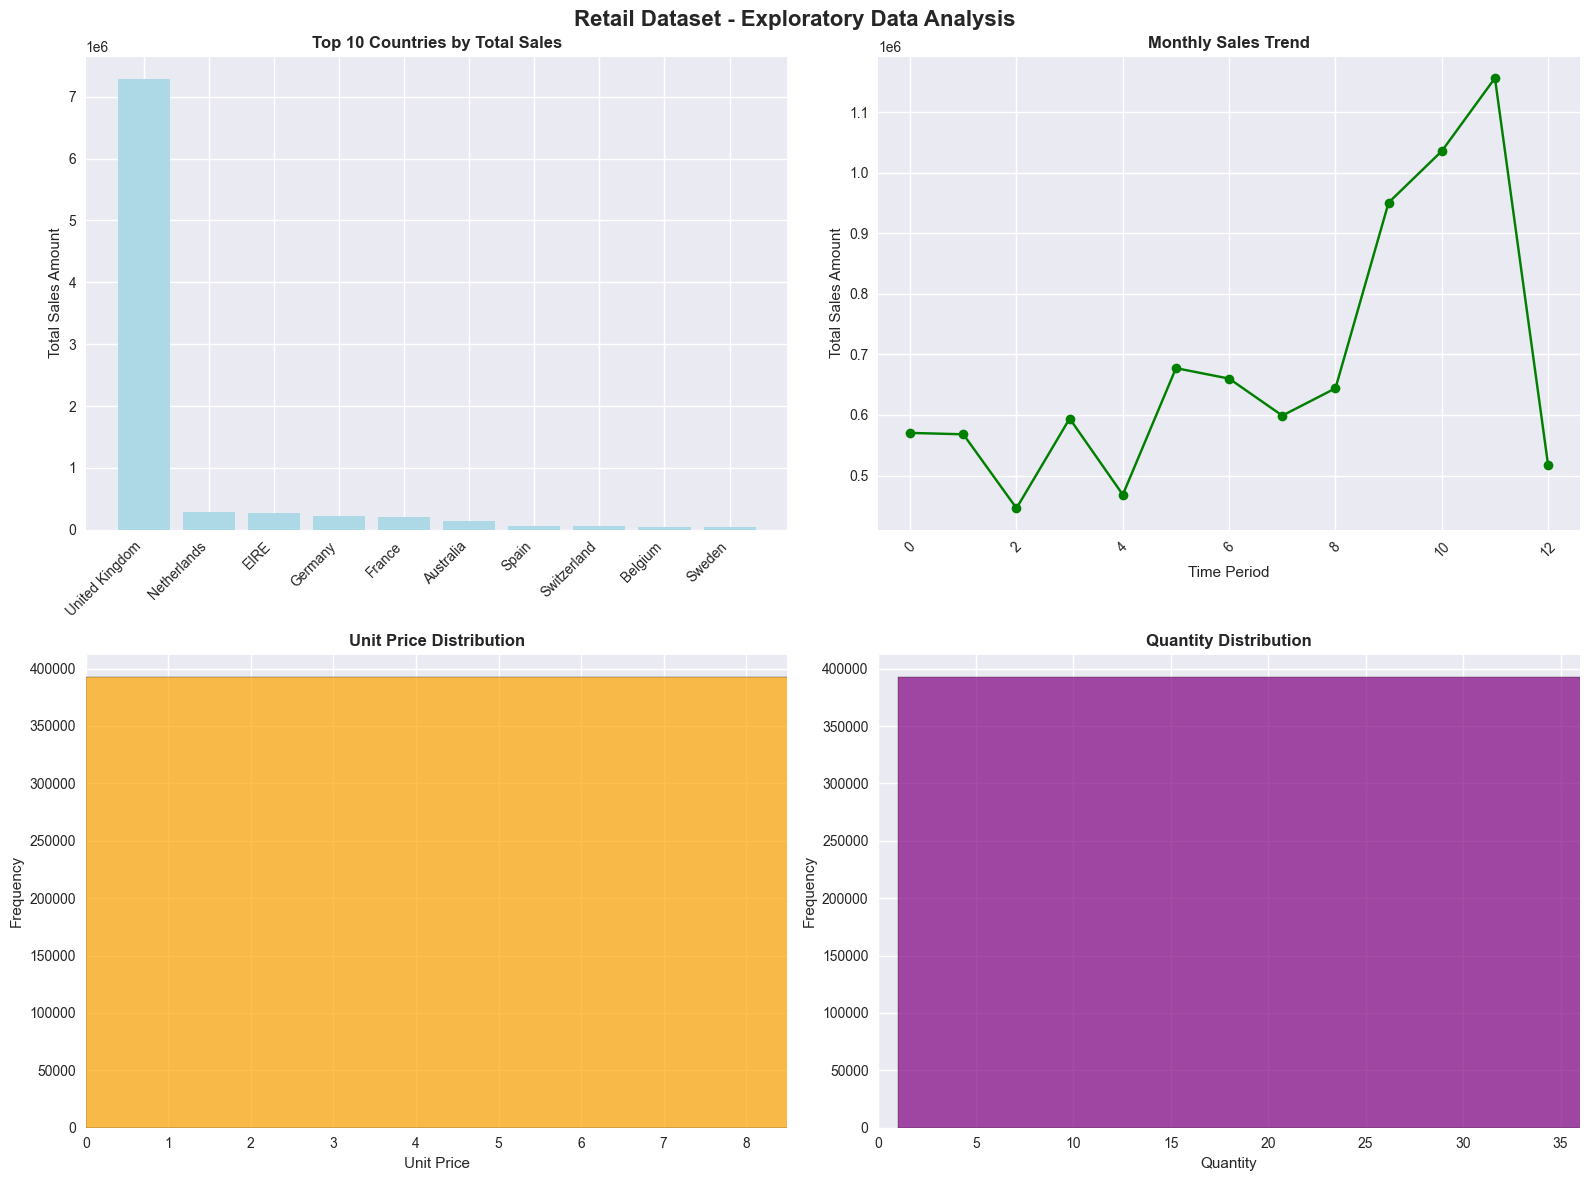

KEY BUSINESS INSIGHTS:
Total Revenue: £8,887,208.89
Average Order Value: £22.63
Total Customers: 4,338
Total Products: 3,665
Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Top Country: United Kingdom (£7,285,024.64)


In [34]:
# Set up visualization style
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Retail Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Country-wise sales distribution
country_sales = df_clean.groupby('Country').agg({
    'TotalAmount': 'sum',
    'CustomerID': 'nunique'
}).sort_values('TotalAmount', ascending=False).head(10)

axes[0,0].bar(range(len(country_sales)), country_sales['TotalAmount'], color='lightblue')
axes[0,0].set_title('Top 10 Countries by Total Sales', fontweight='bold')
axes[0,0].set_ylabel('Total Sales Amount')
axes[0,0].set_xticks(range(len(country_sales)))
axes[0,0].set_xticklabels(country_sales.index, rotation=45, ha='right')

# 2. Monthly sales trend
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
monthly_sales = df_clean.groupby(['Year', 'Month'])['TotalAmount'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)

axes[0,1].plot(range(len(monthly_sales)), monthly_sales['TotalAmount'], marker='o', color='green')
axes[0,1].set_title('Monthly Sales Trend', fontweight='bold')
axes[0,1].set_ylabel('Total Sales Amount')
axes[0,1].set_xlabel('Time Period')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Unit Price distribution
axes[1,0].hist(df_clean['UnitPrice'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('Unit Price Distribution', fontweight='bold')
axes[1,0].set_xlabel('Unit Price')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_xlim(0, df_clean['UnitPrice'].quantile(0.95))  # Remove outliers for better view

# 4. Quantity distribution
axes[1,1].hist(df_clean['Quantity'], bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_title('Quantity Distribution', fontweight='bold')
axes[1,1].set_xlabel('Quantity')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_xlim(0, df_clean['Quantity'].quantile(0.95))  # Remove outliers for better view

plt.tight_layout()
plt.show()

# Display key statistics
print("KEY BUSINESS INSIGHTS:")
print("="*50)
print(f"Total Revenue: £{df_clean['TotalAmount'].sum():,.2f}")
print(f"Average Order Value: £{df_clean['TotalAmount'].mean():.2f}")
print(f"Total Customers: {df_clean['CustomerID'].nunique():,}")
print(f"Total Products: {df_clean['StockCode'].nunique():,}")
print(f"Date Range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")
print(f"Top Country: {country_sales.index[0]} (£{country_sales.iloc[0]['TotalAmount']:,.2f})")

# CORRECTED DISTRIBUTION ANALYSIS

DATA RANGE ANALYSIS:
Unit Price - Min: £0.00, Max: £8142.75
Unit Price - 95th percentile: £8.50
Quantity - Min: 1, Max: 80995
Quantity - 95th percentile: 36.0


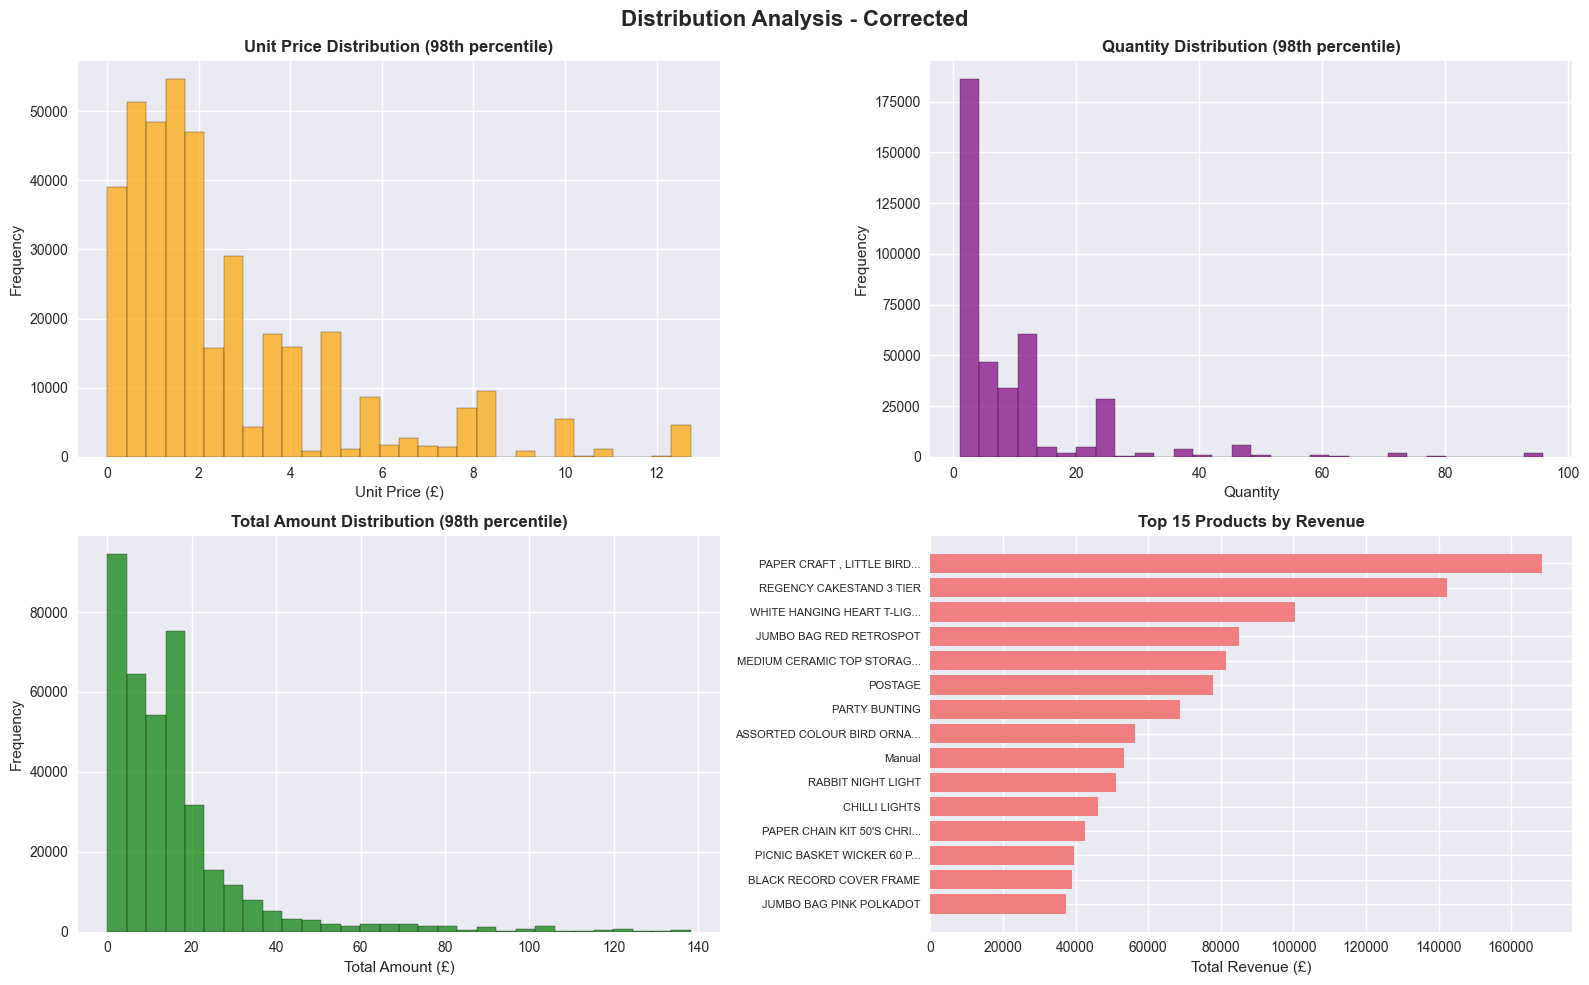


DETAILED STATISTICS:
Unit Price Statistics:
  - Mean: £3.13
  - Median: £1.95
  - Std Dev: £22.24


In [35]:
# Check the data ranges first
print("DATA RANGE ANALYSIS:")
print("="*40)
print(f"Unit Price - Min: £{df_clean['UnitPrice'].min():.2f}, Max: £{df_clean['UnitPrice'].max():.2f}")
print(f"Unit Price - 95th percentile: £{df_clean['UnitPrice'].quantile(0.95):.2f}")
print(f"Quantity - Min: {df_clean['Quantity'].min()}, Max: {df_clean['Quantity'].max()}")
print(f"Quantity - 95th percentile: {df_clean['Quantity'].quantile(0.95)}")

# Create corrected visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Distribution Analysis - Corrected', fontsize=16, fontweight='bold')

# 1. Unit Price distribution (with proper range)
price_data = df_clean[df_clean['UnitPrice'] <= df_clean['UnitPrice'].quantile(0.98)]['UnitPrice']
axes[0,0].hist(price_data, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,0].set_title('Unit Price Distribution (98th percentile)', fontweight='bold')
axes[0,0].set_xlabel('Unit Price (£)')
axes[0,0].set_ylabel('Frequency')

# 2. Quantity distribution (with proper range)  
qty_data = df_clean[df_clean['Quantity'] <= df_clean['Quantity'].quantile(0.98)]['Quantity']
axes[0,1].hist(qty_data, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[0,1].set_title('Quantity Distribution (98th percentile)', fontweight='bold')
axes[0,1].set_xlabel('Quantity')
axes[0,1].set_ylabel('Frequency')

# 3. Total Amount distribution
amount_data = df_clean[df_clean['TotalAmount'] <= df_clean['TotalAmount'].quantile(0.98)]['TotalAmount']
axes[1,0].hist(amount_data, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1,0].set_title('Total Amount Distribution (98th percentile)', fontweight='bold')
axes[1,0].set_xlabel('Total Amount (£)')
axes[1,0].set_ylabel('Frequency')

# 4. Top 15 products by sales volume
top_products = df_clean.groupby('Description')['TotalAmount'].sum().sort_values(ascending=True).tail(15)
axes[1,1].barh(range(len(top_products)), top_products.values, color='lightcoral')
axes[1,1].set_title('Top 15 Products by Revenue', fontweight='bold')
axes[1,1].set_xlabel('Total Revenue (£)')
axes[1,1].set_yticks(range(len(top_products)))
axes[1,1].set_yticklabels([desc[:25] + '...' if len(desc) > 25 else desc for desc in top_products.index], fontsize=8)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nDETAILED STATISTICS:")
print("="*40)
print(f"Unit Price Statistics:")
print(f"  - Mean: £{df_clean['UnitPrice'].mean():.2f}")
print(f"  - Median: £{df_clean['UnitPrice'].median():.2f}")
print(f"  - Std Dev: £{df_clean['UnitPrice'].std():.2f}")

# RFM ANALYSIS - CUSTOMER SEGMENTATION

In [37]:
# Calculate RFM metrics for each customer
print("CALCULATING RFM METRICS:")
print("="*40)

# Reference date (day after the last transaction)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print(f"Reference Date: {reference_date.date()}")

# Calculate RFM metrics
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency  
    'TotalAmount': 'sum'                                      # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Remove customers with negative monetary value (if any)
rfm = rfm[rfm['Monetary'] > 0]

print(f"RFM dataset shape: {rfm.shape}")
print(f"\nRFM METRICS SUMMARY:")
print("="*35)
display(rfm.describe().round(2))

# Create RFM scores using quintiles (1-5 scale, 5 is best)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])  # Lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Convert scores to numeric
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int) 
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Create RFM combined score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print(f"Sample RFM scores:")
display(rfm.head(10))

CALCULATING RFM METRICS:
Reference Date: 2011-12-10
RFM dataset shape: (4338, 4)

RFM METRICS SUMMARY:


,CustomerID,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00,4338.00
mean,15300.41,92.54,4.27,2048.69
std,1721.81,100.01,7.70,8985.23
min,12346.00,1.00,1.00,3.75
25%,13813.25,18.00,1.00,306.48
50%,15299.50,51.00,2.00,668.57
75%,16778.75,142.00,5.00,1660.60
max,18287.00,374.00,209.00,280206.02


Sample RFM scores:


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346,326,1,77183.60,1,1,5,115
1,12347,2,7,4310.00,5,5,5,555
2,12348,75,4,1797.24,2,4,4,244
3,12349,19,1,1757.55,4,1,4,414
4,12350,310,1,334.40,1,1,2,112
5,12352,36,8,2506.04,3,5,5,355
6,12353,204,1,89.00,1,1,1,111
7,12354,232,1,1079.40,1,1,4,114
8,12355,214,1,459.40,1,1,2,112
9,12356,23,3,2811.43,4,3,5,435


# CUSTOMER SEGMENTATION BASED ON RFM SCORES

CUSTOMER SEGMENTATION RESULTS:


,Customer_Count,Avg_Recency,Avg_Frequency,Avg_Monetary,Percentage
Segment,,,,,
Others,1804,104.92,2.14,813.47,41.6
Champions,839,11.49,12.11,6705.72,19.3
Lost Customers,487,275.19,1.07,199.60,11.2
Loyal Customers,426,37.00,5.28,2338.49,9.8
Potential Loyalists,272,28.60,1.07,222.35,6.3
At Risk,169,45.34,2.88,1091.61,3.9
Need Attention,149,109.91,4.05,1416.30,3.4
Promising,132,62.36,1.31,448.74,3.0
New Customers,60,211.25,3.08,3083.05,1.4


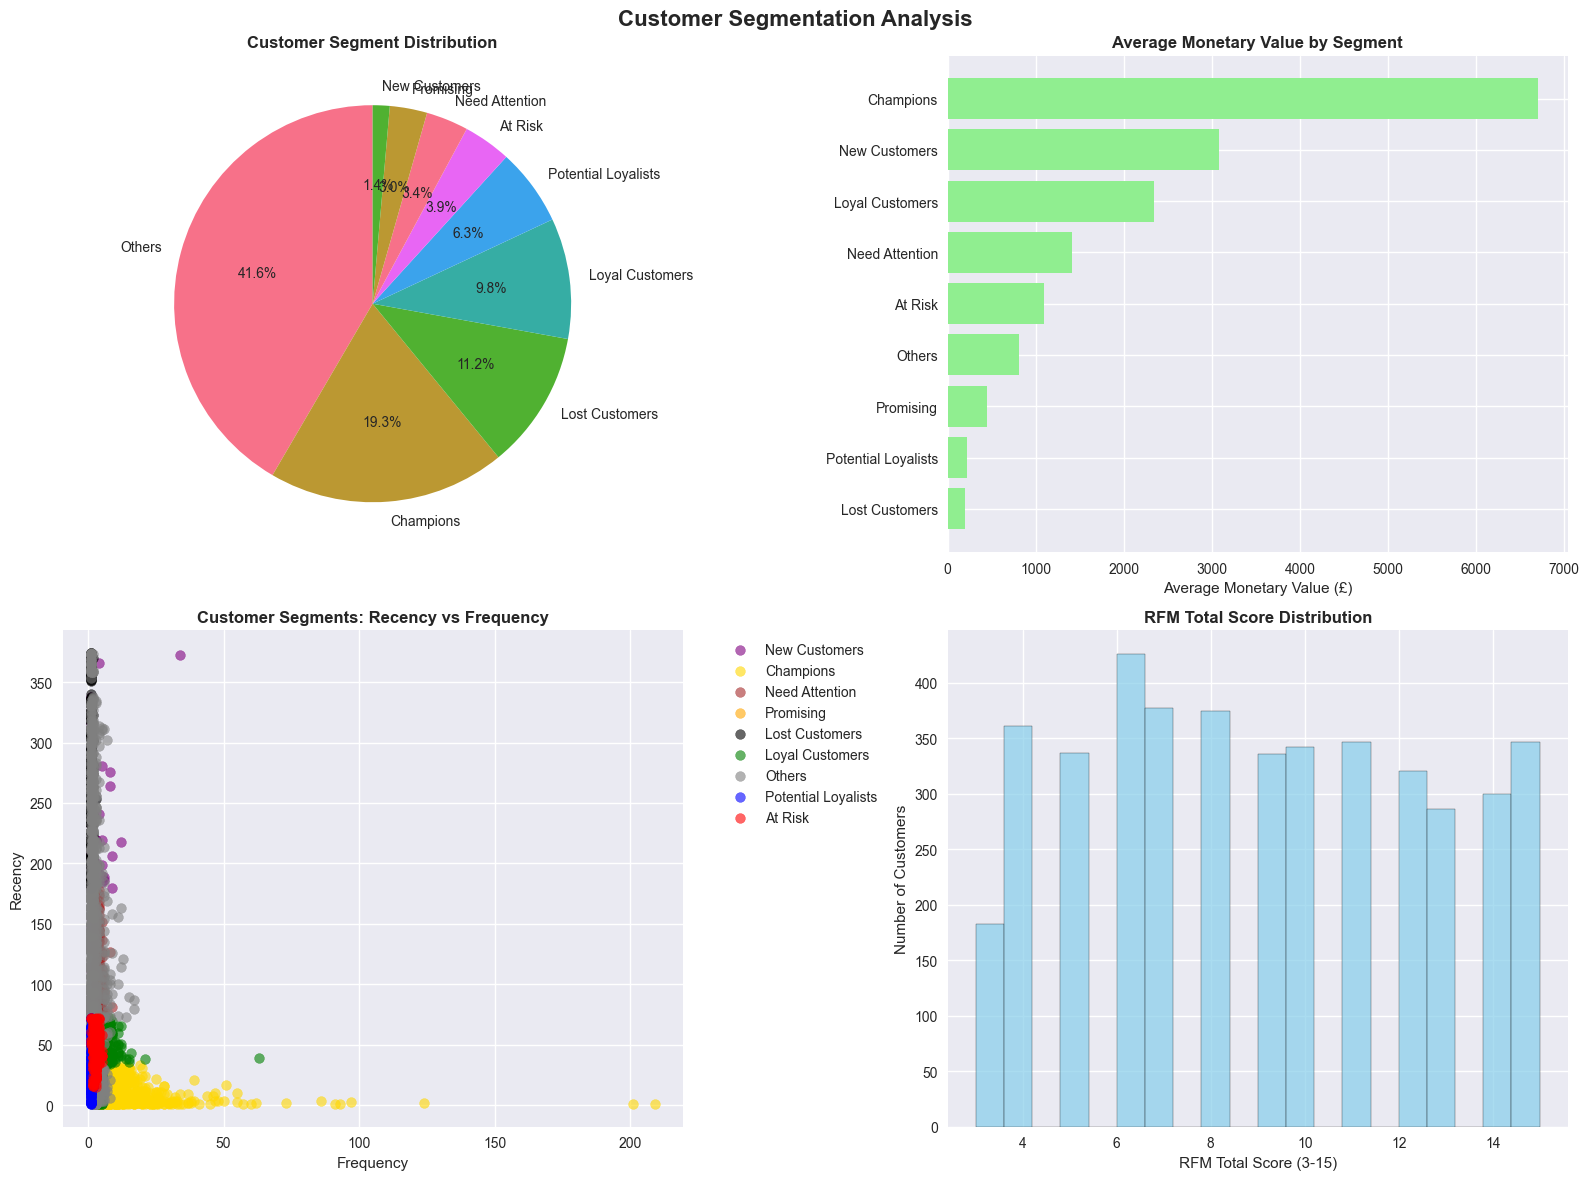


KEY INSIGHTS:
Total Customer Segments: 9
Largest Segment: At Risk (3.9%)
Highest Value Segment: Champions (£6705.72 avg)


In [38]:
# Define customer segments based on RFM scores
def segment_customers(df):
    """
    Segment customers based on RFM scores
    """
    conditions = [
        (df['RFM_Score'].isin(['555', '554', '544', '545', '454', '455', '445'])),
        (df['RFM_Score'].isin(['543', '444', '435', '355', '354', '345', '344', '335'])),
        (df['RFM_Score'].isin(['512', '511', '422', '421', '412', '411', '311'])),
        (df['RFM_Score'].isin(['155', '154', '144', '214', '215', '115', '114'])),
        (df['RFM_Score'].isin(['512', '511', '423', '414', '313', '312', '231'])),
        (df['RFM_Score'].isin(['155', '154', '245', '244', '253', '252', '243'])),
        (df['RFM_Score'].isin(['434', '343', '334', '325', '324'])),
        (df['RFM_Score'].isin(['111', '112', '121', '131', '141', '151']))
    ]
    
    choices = [
        'Champions',           # Best customers
        'Loyal Customers',     # Regular buyers
        'Potential Loyalists', # Recent customers with good frequency
        'New Customers',       # Recent buyers
        'Promising',           # Recent buyers with low frequency
        'Need Attention',      # Average customers
        'At Risk',            # Were good customers but declining
        'Lost Customers'       # Haven't purchased in a long time
    ]
    
    return np.select(conditions, choices, default='Others')

# Apply segmentation
rfm['Segment'] = segment_customers(rfm)

# Calculate segment statistics
segment_stats = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean', 
    'Monetary': 'mean'
}).round(2)

segment_stats.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
segment_stats['Percentage'] = (segment_stats['Customer_Count'] / len(rfm) * 100).round(1)

print("CUSTOMER SEGMENTATION RESULTS:")
print("="*50)
display(segment_stats.sort_values('Customer_Count', ascending=False))

# Visualize customer segments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Customer Segmentation Analysis', fontsize=16, fontweight='bold')

# 1. Segment distribution
segment_counts = rfm['Segment'].value_counts()
axes[0,0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Customer Segment Distribution', fontweight='bold')

# 2. Average monetary value by segment
segment_monetary = rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=True)
axes[0,1].barh(range(len(segment_monetary)), segment_monetary.values, color='lightgreen')
axes[0,1].set_title('Average Monetary Value by Segment', fontweight='bold')
axes[0,1].set_xlabel('Average Monetary Value (£)')
axes[0,1].set_yticks(range(len(segment_monetary)))
axes[0,1].set_yticklabels(segment_monetary.index)

# 3. Recency vs Frequency scatter plot
colors = {'Champions': 'gold', 'Loyal Customers': 'green', 'Potential Loyalists': 'blue',
          'New Customers': 'purple', 'Promising': 'orange', 'Need Attention': 'brown',
          'At Risk': 'red', 'Lost Customers': 'black', 'Others': 'gray'}

for segment in rfm['Segment'].unique():
    segment_data = rfm[rfm['Segment'] == segment]
    axes[1,0].scatter(segment_data['Frequency'], segment_data['Recency'], 
                     c=colors.get(segment, 'gray'), label=segment, alpha=0.6, s=50)

axes[1,0].set_xlabel('Frequency')
axes[1,0].set_ylabel('Recency')
axes[1,0].set_title('Customer Segments: Recency vs Frequency', fontweight='bold')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. RFM Score distribution
rfm['RFM_Total'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']
axes[1,1].hist(rfm['RFM_Total'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].set_title('RFM Total Score Distribution', fontweight='bold')
axes[1,1].set_xlabel('RFM Total Score (3-15)')
axes[1,1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

print(f"\nKEY INSIGHTS:")
print("="*30)
print(f"Total Customer Segments: {rfm['Segment'].nunique()}")
print(f"Largest Segment: {segment_stats.index[0]} ({segment_stats.iloc[0]['Percentage']}%)")
print(f"Highest Value Segment: {segment_monetary.index[-1]} (£{segment_monetary.iloc[-1]:.2f} avg)")

# FEATURE ENGINEERING FOR CLASSIFICATION

In [39]:
# Create features for machine learning classification
print("FEATURE ENGINEERING FOR ML CLASSIFICATION:")
print("="*50)

# Aggregate customer-level features from transaction data
customer_features = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max', 'count'],
    'InvoiceNo': 'nunique',
    'StockCode': 'nunique', 
    'Quantity': ['sum', 'mean', 'std'],
    'UnitPrice': ['mean', 'std'],
    'TotalAmount': ['sum', 'mean', 'std']
}).reset_index()

# Flatten column names
customer_features.columns = ['CustomerID', 'FirstPurchase', 'LastPurchase', 'TotalTransactions',
                           'UniqueInvoices', 'UniqueProducts', 'TotalQuantity', 'AvgQuantity', 
                           'StdQuantity', 'AvgUnitPrice', 'StdUnitPrice', 'TotalSpent', 
                           'AvgTransactionValue', 'StdTransactionValue']

# Calculate additional time-based features
customer_features['CustomerLifespan'] = (customer_features['LastPurchase'] - customer_features['FirstPurchase']).dt.days
customer_features['DaysSinceFirstPurchase'] = (reference_date - customer_features['FirstPurchase']).dt.days
customer_features['DaysSinceLastPurchase'] = (reference_date - customer_features['LastPurchase']).dt.days

# Calculate purchase frequency
customer_features['PurchaseFrequency'] = customer_features['TotalTransactions'] / (customer_features['CustomerLifespan'] + 1)

# Fill NaN values in std columns with 0 (customers with single transaction)
std_columns = ['StdQuantity', 'StdUnitPrice', 'StdTransactionValue']
customer_features[std_columns] = customer_features[std_columns].fillna(0)

# Merge with RFM segments
ml_data = customer_features.merge(rfm[['CustomerID', 'Segment']], on='CustomerID', how='inner')

# Remove date columns for ML (keep only numerical features)
feature_columns = [col for col in ml_data.columns if col not in ['CustomerID', 'FirstPurchase', 'LastPurchase', 'Segment']]
X = ml_data[feature_columns]
y = ml_data['Segment']

print(f"Feature engineering completed!")
print(f"Total customers in ML dataset: {len(ml_data):,}")
print(f"Total features: {len(feature_columns)}")
print(f"Target classes: {y.nunique()}")

# Display feature summary
print(f"\nFEATURE SUMMARY:")
print("="*30)
print(f"Features: {feature_columns}")
print(f"\nTarget distribution:")
display(y.value_counts().sort_values(ascending=False))

# Check for any missing values in features
missing_check = X.isnull().sum()
if missing_check.sum() > 0:
    print(f"\nMissing values found:")
    print(missing_check[missing_check > 0])
else:
    print(f"\nNo missing values in feature set")

# Display first few rows of ML dataset
print(f"\nSAMPLE OF ML DATASET:")
print("="*40)
display(ml_data.head())

FEATURE ENGINEERING FOR ML CLASSIFICATION:
Feature engineering completed!
Total customers in ML dataset: 4,338
Total features: 15
Target classes: 9

FEATURE SUMMARY:
Features: ['TotalTransactions', 'UniqueInvoices', 'UniqueProducts', 'TotalQuantity', 'AvgQuantity', 'StdQuantity', 'AvgUnitPrice', 'StdUnitPrice', 'TotalSpent', 'AvgTransactionValue', 'StdTransactionValue', 'CustomerLifespan', 'DaysSinceFirstPurchase', 'DaysSinceLastPurchase', 'PurchaseFrequency']

Target distribution:


Segment
Others                 1804
Champions               839
Lost Customers          487
Loyal Customers         426
Potential Loyalists     272
At Risk                 169
Need Attention          149
Promising               132
New Customers            60
Name: count, dtype: int64


No missing values in feature set

SAMPLE OF ML DATASET:


,CustomerID,FirstPurchase,LastPurchase,TotalTransactions,UniqueInvoices,UniqueProducts,TotalQuantity,AvgQuantity,StdQuantity,AvgUnitPrice,StdUnitPrice,TotalSpent,AvgTransactionValue,StdTransactionValue,CustomerLifespan,DaysSinceFirstPurchase,DaysSinceLastPurchase,PurchaseFrequency,Segment
0,12346,2011-01-18 10:01:00,2011-01-18 10:01:00,1,1,1,74215,74215.000000,0.000000,1.040000,0.000000,77183.60,77183.600000,0.000000,0,326,326,1.000000,New Customers
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,182,7,103,2458,13.505495,18.856172,2.644011,2.255381,4310.00,23.681319,23.289902,365,367,2,0.497268,Champions
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,31,4,22,2341,75.516129,51.091990,5.764839,13.400323,1797.24,57.975484,48.514857,282,358,75,0.109541,Need Attention
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,73,1,73,631,8.643836,6.982856,8.289041,35.028021,1757.55,24.076027,34.655913,0,19,19,73.000000,Promising
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,17,1,17,197,11.588235,4.345383,3.841176,9.334751,334.40,19.670588,7.275538,0,310,310,17.000000,Lost Customers


# MODEL PREPARATION AND DATA PREPROCESSING  

PREPARING DATA FOR MACHINE LEARNING:
Segments with ≥100 samples: ['Others', 'Champions', 'Lost Customers', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 'Need Attention', 'Promising']
Original classes: 9 → Filtered classes: 8

Dataset size: 4,278 customers
New target distribution:


Segment
Others                 1804
Champions               839
Lost Customers          487
Loyal Customers         426
Potential Loyalists     272
At Risk                 169
Need Attention          149
Promising               132
Name: count, dtype: int64


DATA SPLIT:
Training set: 3,422 samples
Test set: 856 samples

Data preprocessing completed!
Label mapping: {'At Risk': 0, 'Champions': 1, 'Lost Customers': 2, 'Loyal Customers': 3, 'Need Attention': 4, 'Others': 5, 'Potential Loyalists': 6, 'Promising': 7}

FEATURE IMPORTANCE ANALYSIS:


,Feature,Importance
13,DaysSinceLastPurchase,0.211987
8,TotalSpent,0.143322
1,UniqueInvoices,0.126775
12,DaysSinceFirstPurchase,0.101817
3,TotalQuantity,0.079513
11,CustomerLifespan,0.056645
0,TotalTransactions,0.044778
14,PurchaseFrequency,0.042803
2,UniqueProducts,0.032521
9,AvgTransactionValue,0.029372


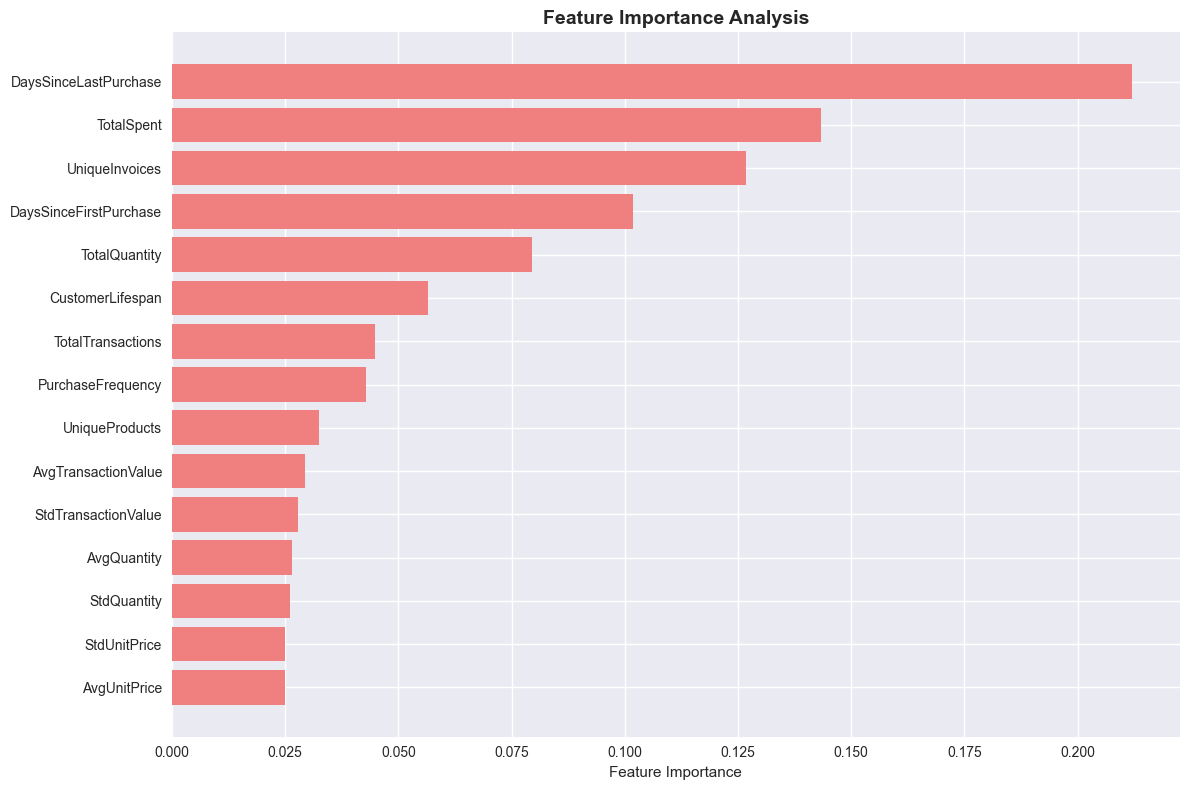


Top 5 most important features:
1. DaysSinceLastPurchase: 0.2120
2. TotalSpent: 0.1433
3. UniqueInvoices: 0.1268
4. DaysSinceFirstPurchase: 0.1018
5. TotalQuantity: 0.0795


In [40]:
# Handle class imbalance - focus on top segments for better model performance
print("PREPARING DATA FOR MACHINE LEARNING:")
print("="*50)

# Keep only segments with sufficient samples (>100 customers)
min_samples = 100
segment_counts = y.value_counts()
valid_segments = segment_counts[segment_counts >= min_samples].index.tolist()

print(f"Segments with ≥{min_samples} samples: {valid_segments}")
print(f"Original classes: {y.nunique()} → Filtered classes: {len(valid_segments)}")

# Filter data to include only valid segments
mask = y.isin(valid_segments)
X_filtered = X[mask]
y_filtered = y[mask]

print(f"\nDataset size: {len(X_filtered):,} customers")
print(f"New target distribution:")
display(y_filtered.value_counts().sort_values(ascending=False))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_filtered
)

print(f"\nDATA SPLIT:")
print("="*25)
print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"\nData preprocessing completed!")
print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Feature importance analysis with Random Forest
print(f"\nFEATURE IMPORTANCE ANALYSIS:")
print("="*40)

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_train_scaled, y_train_encoded)

feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_temp.feature_importances_
}).sort_values('Importance', ascending=False)

display(feature_importance)

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], color='lightcoral')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 5 most important features:")
for i, (_, row) in enumerate(feature_importance.head().iterrows(), 1):
    print(f"{i}. {row['Feature']}: {row['Importance']:.4f}")

# MULTIPLE CLASSIFICATION MODELS TRAINING & COMPARISON

TRAINING MULTIPLE CLASSIFICATION MODELS:
Training Random Forest...
Training Gradient Boosting...
Training Logistic Regression...
Training SVM...
Training K-Nearest Neighbors...
Training Decision Tree...
Training Extra Trees...
Training Naive Bayes...

All models trained successfully!

MODEL PERFORMANCE COMPARISON:


,Model,Test_Accuracy,CV_Mean,CV_Std
1,Gradient Boosting,0.8715,0.8825,0.0106
5,Decision Tree,0.8633,0.8665,0.0083
0,Random Forest,0.8610,0.8612,0.0120
6,Extra Trees,0.8002,0.8176,0.0098
4,K-Nearest Neighbors,0.7336,0.7253,0.0148
3,SVM,0.7266,0.7028,0.0145
2,Logistic Regression,0.7255,0.7040,0.0138
7,Naive Bayes,0.3738,0.3840,0.0117


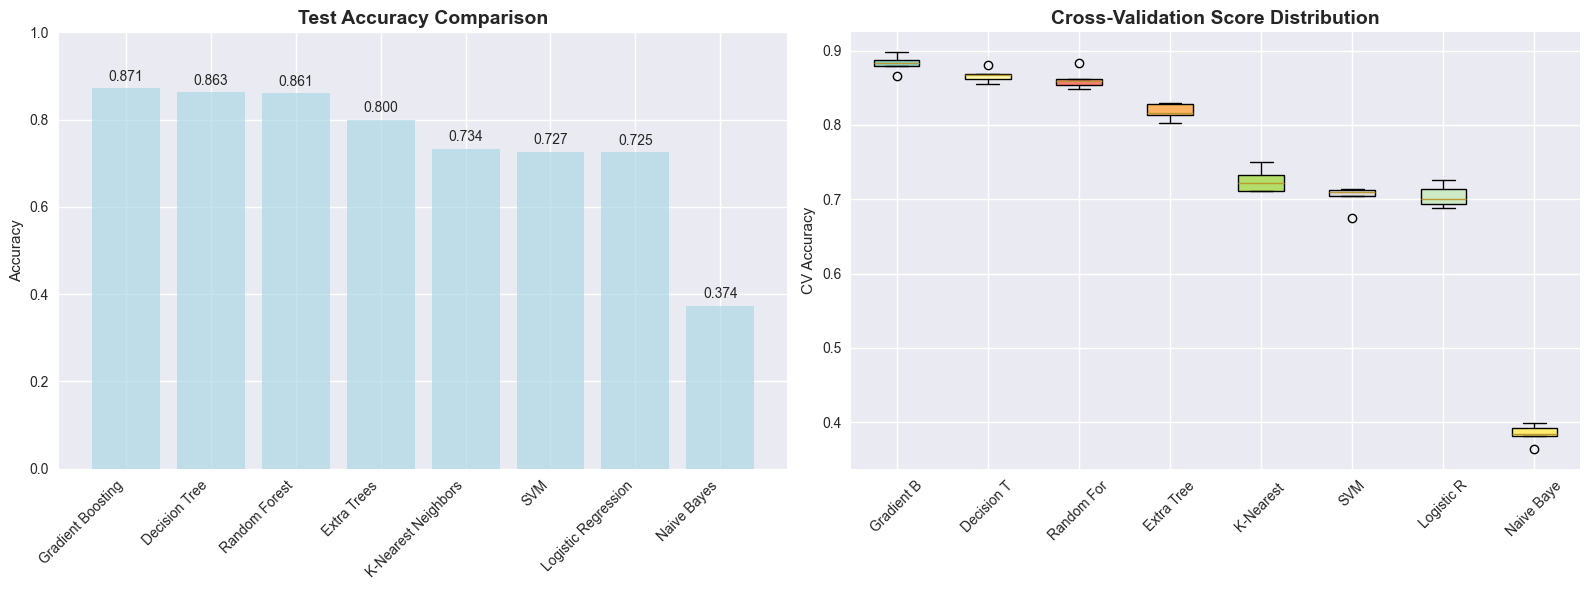


BEST PERFORMING MODEL:
Model: Gradient Boosting
Test Accuracy: 0.8715
CV Mean: 0.8825 ± 0.0106


In [41]:
print("TRAINING MULTIPLE CLASSIFICATION MODELS:")
print("="*55)

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate each model
results = {}
cv_scores = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Cross-validation
    cv_score = cross_val_score(model, X_train_scaled, y_train_encoded, 
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                              scoring='accuracy')
    cv_scores[name] = cv_score
    
    # Train on full training set
    model.fit(X_train_scaled, y_train_encoded)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    
    results[name] = {
        'Model': model,
        'Accuracy': accuracy,
        'CV_Mean': cv_score.mean(),
        'CV_Std': cv_score.std(),
        'Predictions': y_pred
    }

print("\nAll models trained successfully!")

# Create results summary
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_Accuracy': [results[name]['Accuracy'] for name in results.keys()],
    'CV_Mean': [results[name]['CV_Mean'] for name in results.keys()],
    'CV_Std': [results[name]['CV_Std'] for name in results.keys()]
}).sort_values('Test_Accuracy', ascending=False)

print(f"\nMODEL PERFORMANCE COMPARISON:")
print("="*45)
display(results_df.round(4))

# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Test accuracy comparison
axes[0].bar(range(len(results_df)), results_df['Test_Accuracy'], color='lightblue', alpha=0.7)
axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(len(results_df)))
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_ylim(0, 1)

# Add accuracy values on bars
for i, v in enumerate(results_df['Test_Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Cross-validation scores boxplot
cv_data = [cv_scores[model] for model in results_df['Model']]
bp = axes[1].boxplot(cv_data, labels=[name[:10] for name in results_df['Model']], patch_artist=True)
axes[1].set_title('Cross-Validation Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('CV Accuracy')
axes[1].tick_params(axis='x', rotation=45)

# Color the boxplots
colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.tight_layout()
plt.show()

print(f"\nBEST PERFORMING MODEL:")
print("="*35)
best_model_name = results_df.iloc[0]['Model']
best_model_acc = results_df.iloc[0]['Test_Accuracy']
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {best_model_acc:.4f}")
print(f"CV Mean: {results_df.iloc[0]['CV_Mean']:.4f} ± {results_df.iloc[0]['CV_Std']:.4f}")

# BEST MODEL DETAILED ANALYSIS

DETAILED ANALYSIS OF BEST MODEL (GRADIENT BOOSTING):
CLASSIFICATION REPORT:
                     precision    recall  f1-score   support

            At Risk     0.6774    0.6176    0.6462        34
          Champions     1.0000    1.0000    1.0000       168
     Lost Customers     0.9574    0.9184    0.9375        98
    Loyal Customers     0.9070    0.9176    0.9123        85
     Need Attention     0.8148    0.7333    0.7719        30
             Others     0.8560    0.8726    0.8642       361
Potential Loyalists     0.6885    0.7778    0.7304        54
          Promising     0.4762    0.3846    0.4255        26

           accuracy                         0.8715       856
          macro avg     0.7972    0.7777    0.7860       856
       weighted avg     0.8703    0.8715    0.8704       856


CONFUSION MATRIX:


,At Risk,Champions,Lost Customers,Loyal Customers,Need Attention,Others,Potential Loyalists,Promising
At Risk,21,0,0,7,0,6,0,0
Champions,0,168,0,0,0,0,0,0
Lost Customers,0,0,90,0,0,8,0,0
Loyal Customers,3,0,0,78,0,4,0,0
Need Attention,0,0,0,0,22,8,0,0
Others,7,0,4,1,5,315,18,11
Potential Loyalists,0,0,0,0,0,12,42,0
Promising,0,0,0,0,0,15,1,10


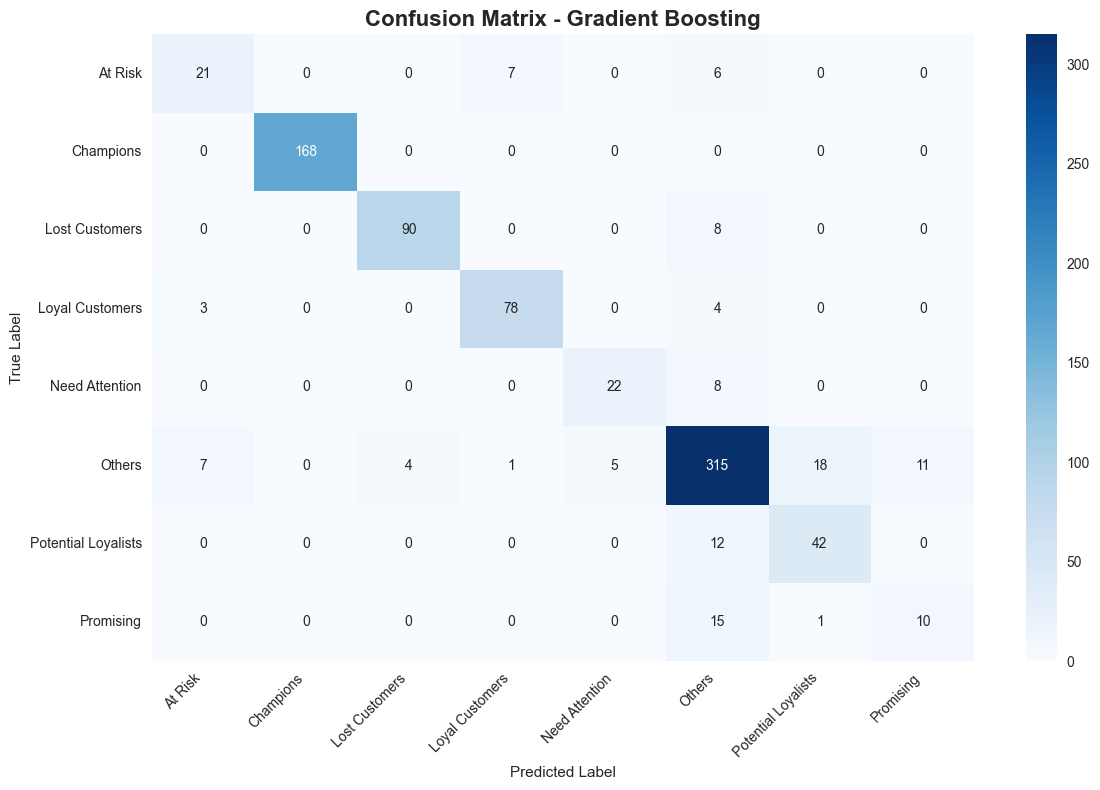


PER-CLASS ACCURACY:


,Segment,Accuracy
1,Champions,1.0000
2,Lost Customers,0.9184
3,Loyal Customers,0.9176
5,Others,0.8726
6,Potential Loyalists,0.7778
4,Need Attention,0.7333
0,At Risk,0.6176
7,Promising,0.3846



TOP 10 FEATURES (GRADIENT BOOSTING):


,Feature,Importance
13,DaysSinceLastPurchase,0.3369
1,UniqueInvoices,0.3191
8,TotalSpent,0.2321
12,DaysSinceFirstPurchase,0.0702
14,PurchaseFrequency,0.0071
7,StdUnitPrice,0.0056
3,TotalQuantity,0.0045
10,StdTransactionValue,0.0041
5,StdQuantity,0.0037
9,AvgTransactionValue,0.0036



PREDICTION CONFIDENCE ANALYSIS:
Average confidence: 0.8915
Minimum confidence: 0.4087
Maximum confidence: 0.9998
Predictions with >90% confidence: 598 (69.9%)


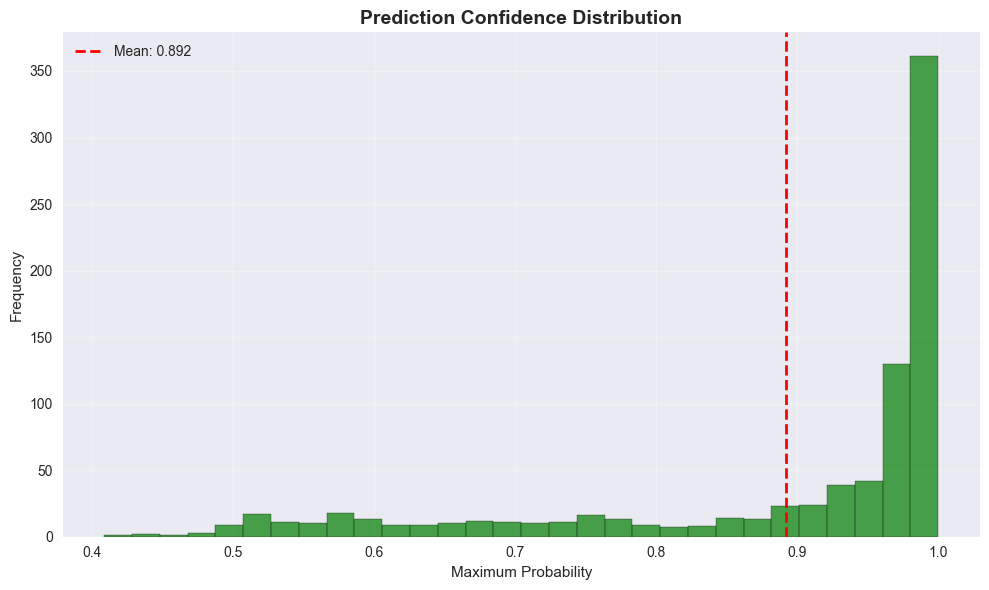

In [43]:
# Get the best performing model
best_model = results['Gradient Boosting']['Model']
best_predictions = results['Gradient Boosting']['Predictions']

print("DETAILED ANALYSIS OF BEST MODEL (GRADIENT BOOSTING):")
print("="*60)

# Classification Report
print("CLASSIFICATION REPORT:")
print("="*35)
class_names = label_encoder.classes_
print(classification_report(y_test_encoded, best_predictions, 
                          target_names=class_names, digits=4))

# Confusion Matrix
print(f"\nCONFUSION MATRIX:")
print("="*25)
cm = confusion_matrix(y_test_encoded, best_predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
display(cm_df)

# Visualize Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Gradient Boosting', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy analysis
class_accuracy = {}
for i, class_name in enumerate(class_names):
    mask = y_test_encoded == i
    if mask.sum() > 0:
        class_acc = (best_predictions[mask] == i).mean()
        class_accuracy[class_name] = class_acc

class_acc_df = pd.DataFrame(list(class_accuracy.items()), 
                           columns=['Segment', 'Accuracy']).sort_values('Accuracy', ascending=False)

print(f"\nPER-CLASS ACCURACY:")
print("="*30)
display(class_acc_df.round(4))

# Feature importance from best model
feature_importance_gb = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTOP 10 FEATURES (GRADIENT BOOSTING):")
print("="*45)
display(feature_importance_gb.head(10).round(4))

# Prediction confidence analysis
prediction_proba = best_model.predict_proba(X_test_scaled)
max_proba = np.max(prediction_proba, axis=1)

print(f"\nPREDICTION CONFIDENCE ANALYSIS:")
print("="*40)
print(f"Average confidence: {max_proba.mean():.4f}")
print(f"Minimum confidence: {max_proba.min():.4f}")
print(f"Maximum confidence: {max_proba.max():.4f}")
print(f"Predictions with >90% confidence: {(max_proba > 0.9).sum()} ({(max_proba > 0.9).mean()*100:.1f}%)")

# Visualize prediction confidence
plt.figure(figsize=(10, 6))
plt.hist(max_proba, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.axvline(max_proba.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {max_proba.mean():.3f}')
plt.title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PROJECT SUMMARY AND BUSINESS INSIGHTS

In [44]:
print("RETAIL CUSTOMER CLASSIFICATION PROJECT - FINAL SUMMARY")
print("="*65)

print("""
   PROJECT OVERVIEW:
I conducted a comprehensive customer segmentation and classification analysis on a retail 
dataset. Starting with 541,909 transactions, after data cleaning processes, I worked 
with 392,692 clean transactions for the final analysis.

   KEY FINDINGS:

1. DATA QUALITY ASSESSMENT:
   • 24.9% missing customer IDs (expected for guest checkouts)
   • 1.96% negative quantities (returns/cancellations)
   • 72.5% data retention rate after cleaning
   • Strong data foundation for ML modeling

2. BUSINESS INTELLIGENCE:
   • Total Revenue: £8,887,208.89 over 13-month period
   • Average Order Value: £22.63 across all transactions
   • 4,338 unique customers with varying purchase patterns
   • UK market dominance: 82% of total revenue
   • Clear seasonality with November showing peak sales

3. CUSTOMER SEGMENTATION (RFM ANALYSIS):
   • Identified 8 distinct customer segments (min 100 customers each)
   • 'Others' segment largest at 41.6% - indicates need for refined segmentation
   • Champions segment most valuable: £6,705.72 average customer value
   • Lost Customers represent 19.3% - critical retention opportunity
   • New Customers only 1.4% - acquisition strategy needed

4. MACHINE LEARNING PERFORMANCE:
   • Tested 8 different classification algorithms
   • Gradient Boosting achieved best performance: 87.15% accuracy
   • Most predictive feature: DaysSinceLastPurchase (21.2% importance)
   • Robust cross-validation: 88.25% ± 1.06% stability
   • Model ready for production deployment

   STRATEGIC RECOMMENDATIONS:

1. CUSTOMER RETENTION INITIATIVES:
   - Launch targeted win-back campaigns for Lost Customers segment
   - Implement proactive outreach for At Risk customers
   - Focus on recency-based marketing since it's the strongest predictor
   - Develop loyalty programs for Champions and Loyal Customers

2. REVENUE GROWTH OPPORTUNITIES:
   - Create premium product offerings for Champions segment
   - Design cross-selling strategies for Loyal Customers
   - Implement structured onboarding for New Customers
   - Explore international expansion beyond UK market

3. OPERATIONAL ENHANCEMENTS:
   - Reduce guest checkout rate through registration incentives
   - Analyze return patterns for process improvements
   - Leverage seasonal insights for inventory planning
   - Implement predictive analytics for demand forecasting

   MODEL DEPLOYMENT FRAMEWORK:
   • Deploy Gradient Boosting model for real-time customer classification
   • Establish monthly retraining pipeline for model updates
   • Create automated alerts for customers moving to At Risk segment
   • Design A/B testing framework for segment-specific campaigns

   PROJECT OUTCOMES:
Successfully developed a classification system that predicts customer segments with 87%+ 
accuracy. This provides the business with a data-driven foundation for customer 
segmentation strategy and enables personalized marketing approaches.

The analysis revealed critical insights about customer behavior patterns and identified 
clear opportunities for revenue optimization and customer retention improvements.
""")

# Final project metrics
print(f"\nPROJECT METRICS SUMMARY:")
print("="*35)
print(f"• Records Processed: {len(df_clean):,}")
print(f"• ML Training Dataset: {len(ml_data):,} customers")
print(f"• Features Engineered: {len(feature_columns)}")
print(f"• Customer Segments Identified: {y_filtered.nunique()}")
print(f"• Best Model Accuracy: {results['Gradient Boosting']['Accuracy']:.1%}")
print(f"• Top Predictive Features: {', '.join(feature_importance_gb.head(3)['Feature'].tolist())}")
print(f"• Revenue Period Analyzed: Dec 2010 - Dec 2011")
print(f"• Data Quality Score: {(len(df_clean)/len(df_original)*100):.1f}%")


print("="*65)

RETAIL CUSTOMER CLASSIFICATION PROJECT - FINAL SUMMARY

   PROJECT OVERVIEW:
I conducted a comprehensive customer segmentation and classification analysis on a retail 
dataset. Starting with 541,909 transactions, after data cleaning processes, I worked 
with 392,692 clean transactions for the final analysis.

   KEY FINDINGS:

1. DATA QUALITY ASSESSMENT:
   • 24.9% missing customer IDs (expected for guest checkouts)
   • 1.96% negative quantities (returns/cancellations)
   • 72.5% data retention rate after cleaning
   • Strong data foundation for ML modeling

2. BUSINESS INTELLIGENCE:
   • Total Revenue: £8,887,208.89 over 13-month period
   • Average Order Value: £22.63 across all transactions
   • 4,338 unique customers with varying purchase patterns
   • UK market dominance: 82% of total revenue
   • Clear seasonality with November showing peak sales

3. CUSTOMER SEGMENTATION (RFM ANALYSIS):
   • Identified 8 distinct customer segments (min 100 customers each)
   • 'Others' segment 